In [1]:
from collections import defaultdict, Counter 
import colorsys
import itertools
import pickle 
import os
import shutil
import subprocess

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.image as mpimg
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from PyPDF2 import PdfFileWriter, PdfFileReader, PdfFileMerger
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from IPython.display import display, HTML

import ot
from scipy.spatial import distance, ConvexHull
from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import fcsparser 
from ete3 import Tree, TreeNode, TreeStyle, TextFace

from utils import *

In [6]:
sample_name = 'BALBc-1'
num_clusters, num_neighbors = get_unique_clusters(sample_name)
fcs_paths = [data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs' for nn in num_neighbors]
tree = build_sample_tree(sample_name, prop_filter=0.15)
tree = calculate_spearman_metric(tree)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)
/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


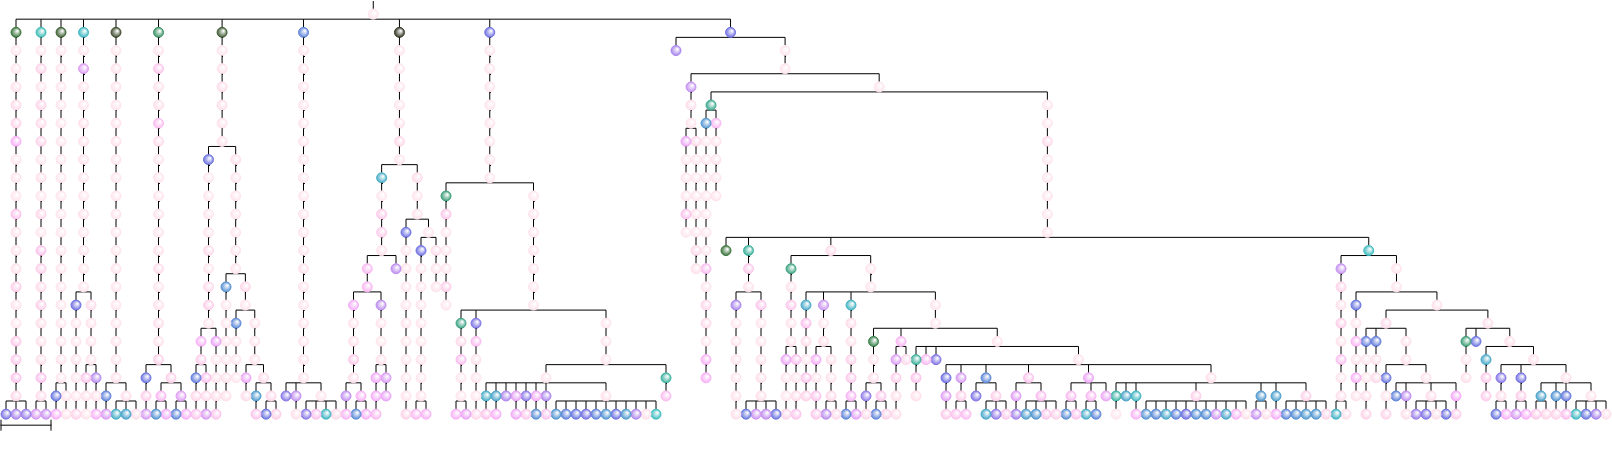

In [18]:
visualize_spearman_metric(num_layers=25, save=False)

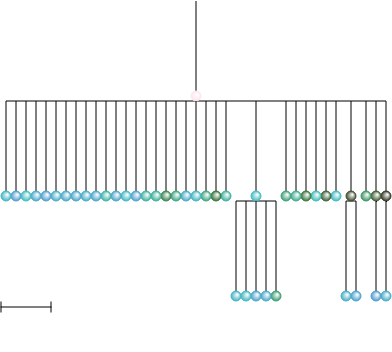

In [20]:
parse_metric_tree(tree, num_layers=None, cutoff=0.2, prevent_nondicotomic=False, save=False)

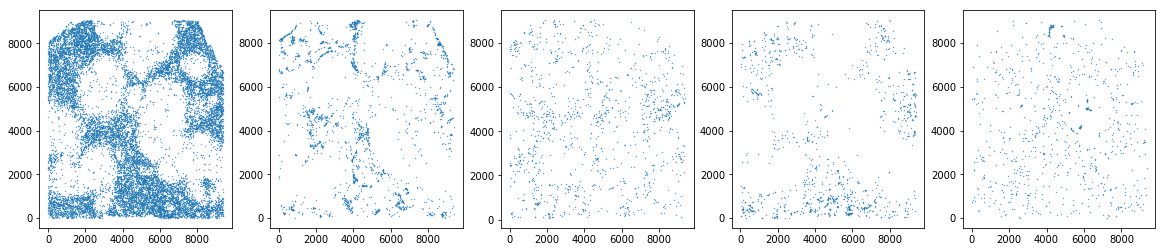

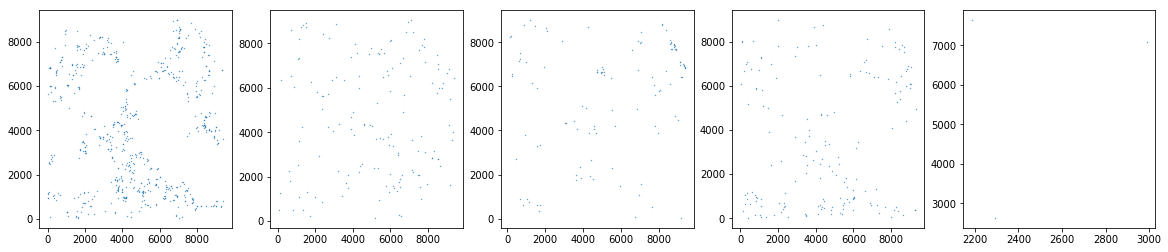

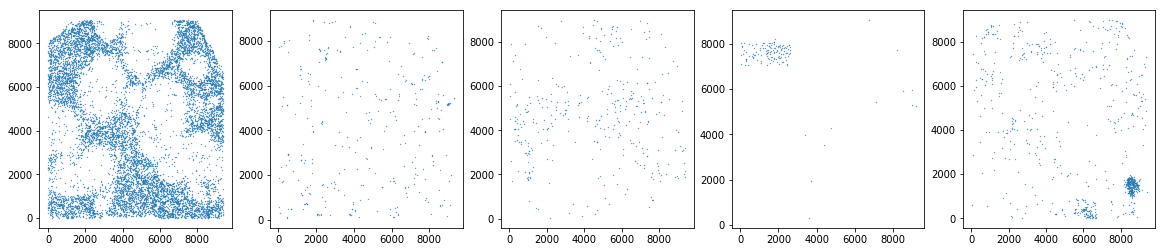

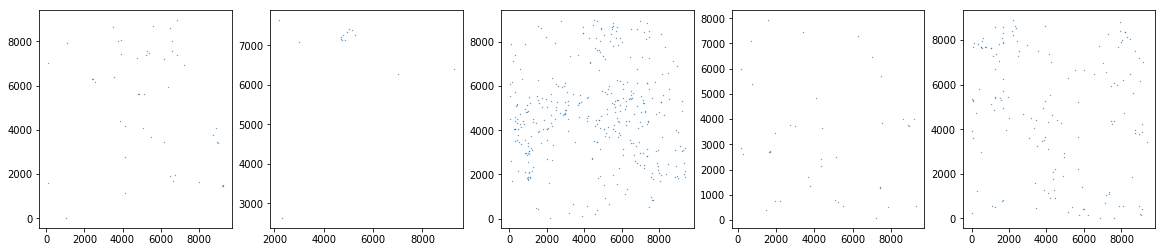

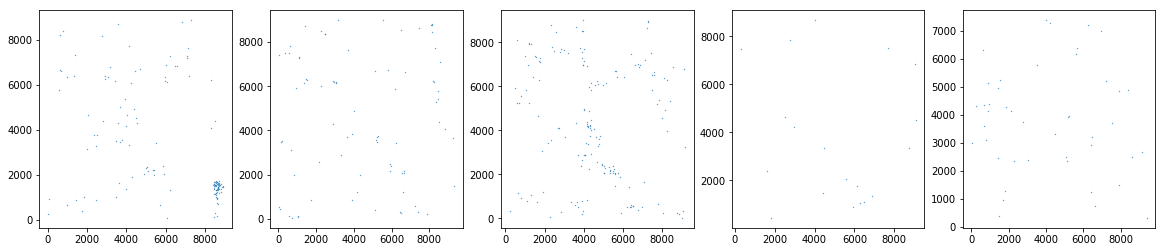

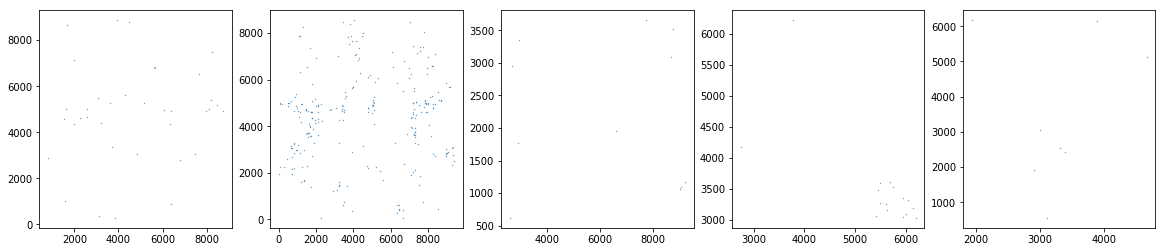

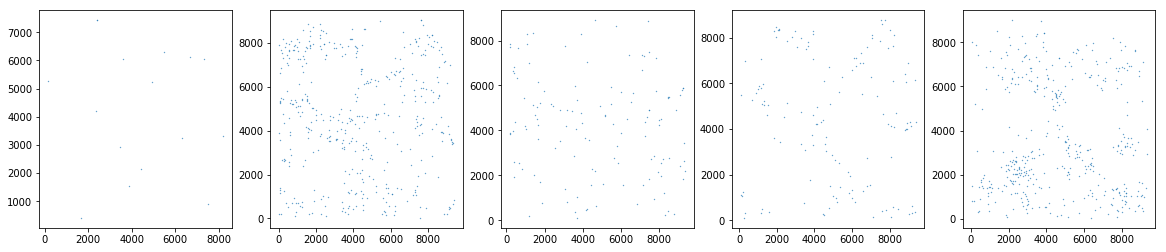

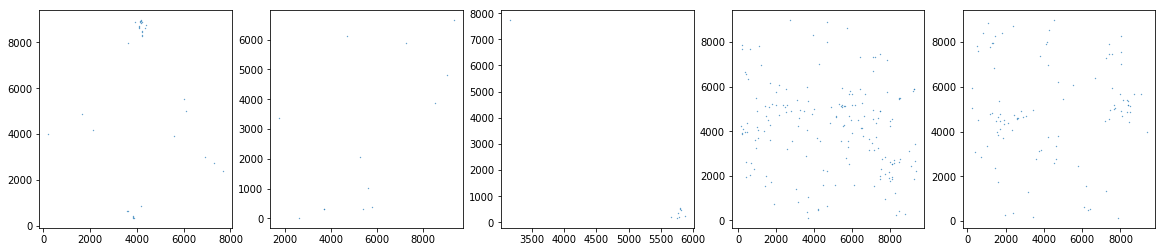

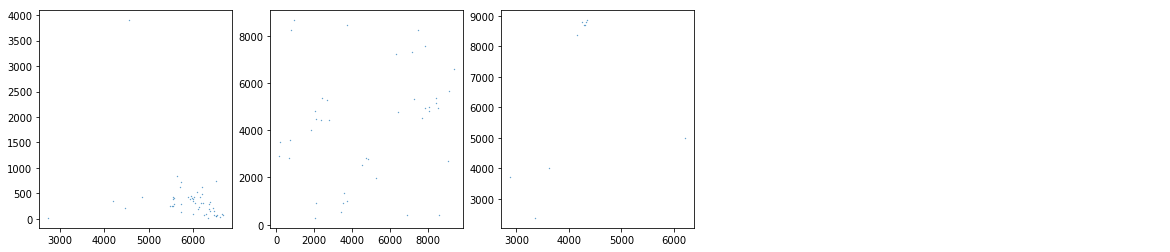

In [21]:
parsed_metric_tree = parse_metric_tree(tree, num_layers=5, cutoff=0.2, return_tree=True, prevent_nondicotomic=False)
visualize_metric_tree_clusters(parsed_metric_tree)

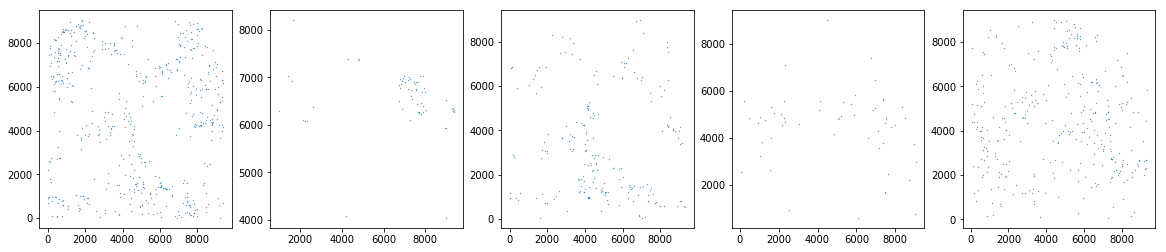

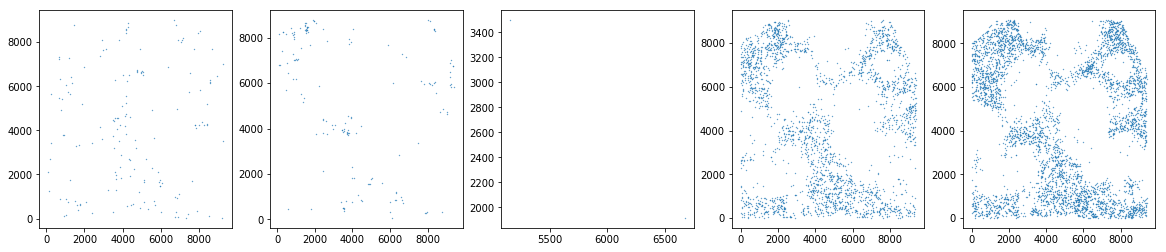

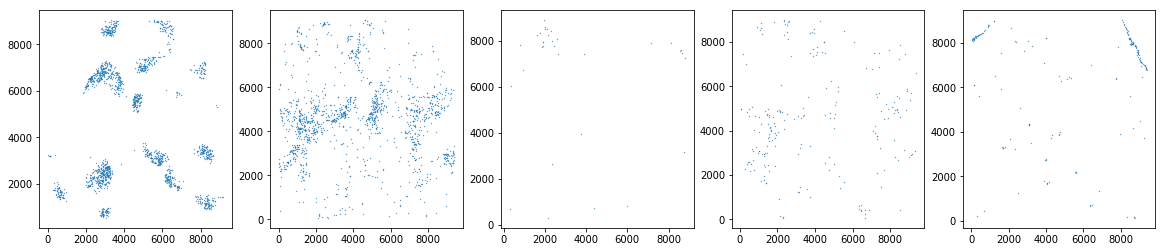

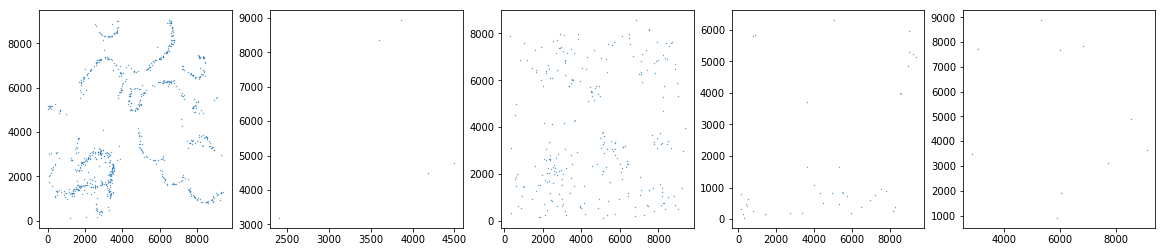

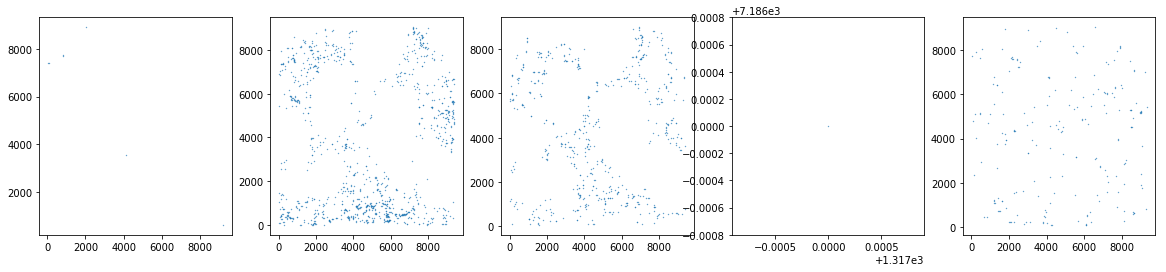

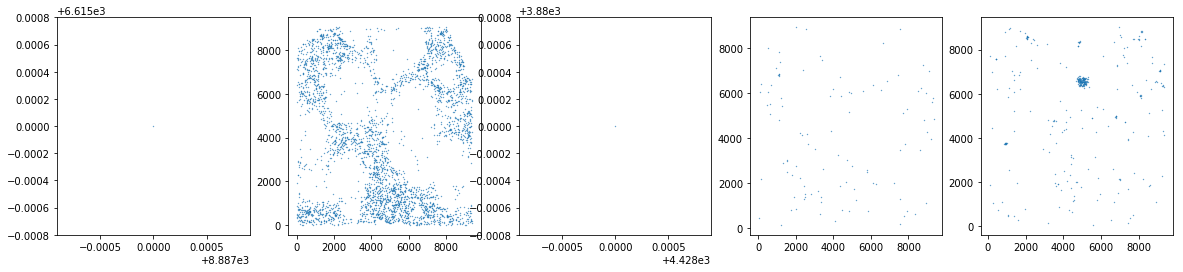

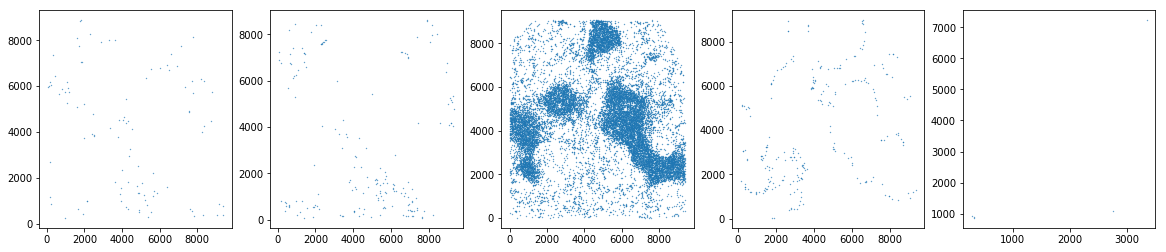

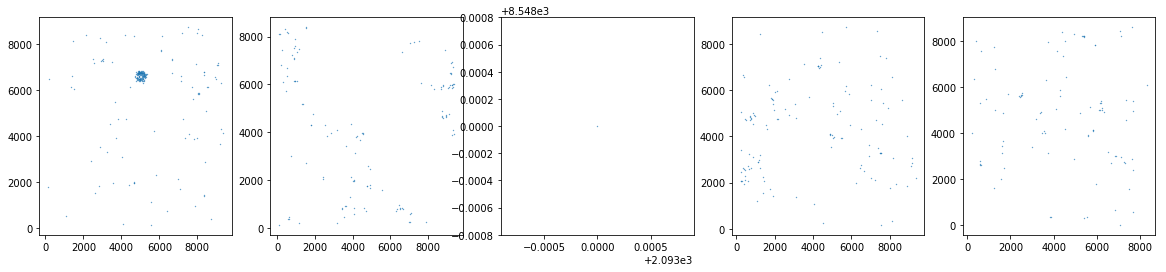

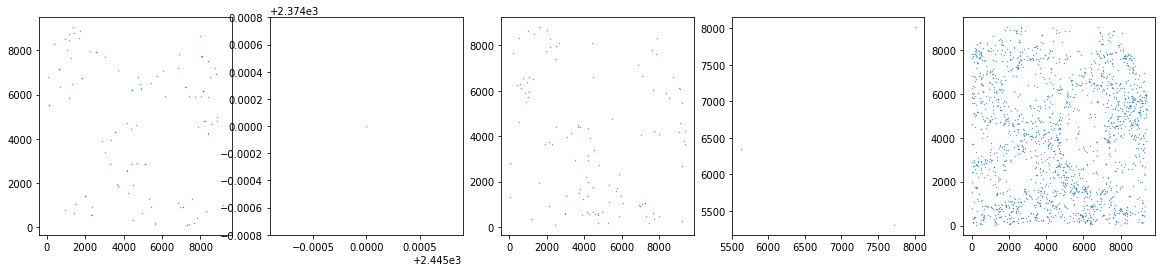

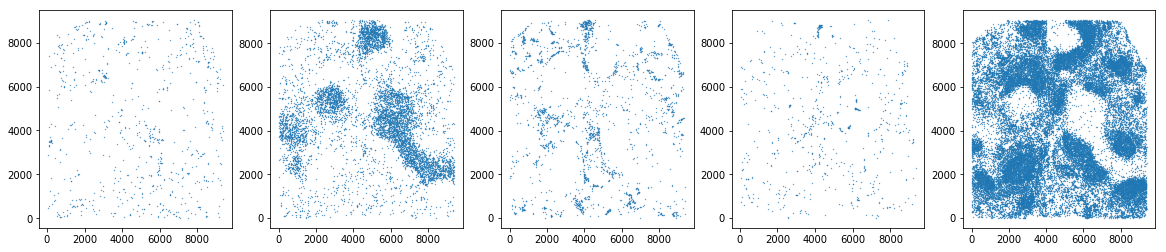

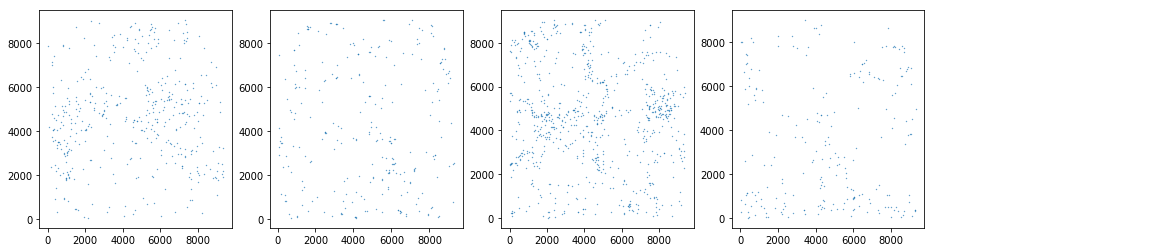

In [22]:
supplementary_data = pd.read_csv('../Suppl.Table2.CODEX_paper_MRLdatasetexpression.csv')
supplementary_data = supplementary_data[['X.X', 'Y.Y', 'Z.Z', 'sample_Xtile_Ytile', 
                                         'CD45', 'Imaging phenotype cluster ID']]
supplementary_data = supplementary_data[supplementary_data['sample_Xtile_Ytile'].str.contains('BALBc-1')]
supplementary_data.rename(columns={'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
supplementary_data = convert_coordinates(supplementary_data)
suppl_image_groups = supplementary_data.groupby('Imaging phenotype cluster ID')
for ind, (_, group) in enumerate(suppl_image_groups):
    if ind % 5 == 0:
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    ax[ind%5].scatter(group['X'], group['Y'], s=0.1)
    if ind % 5 == 4:
        plt.show()
if ind % 5 != 4:
    for i in range(1, 5 - ind%5):
        ax[ind%5 + i].axis('off')
    plt.show()

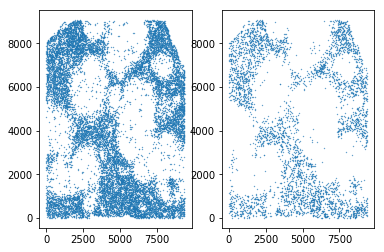

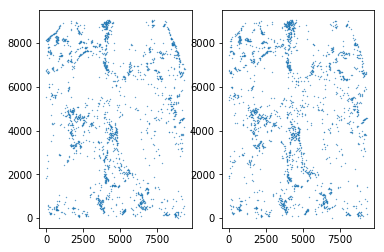

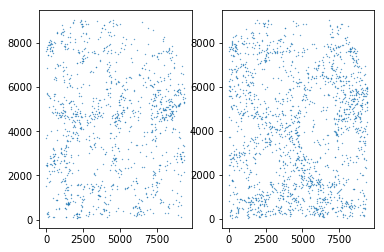

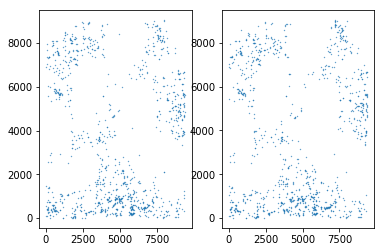

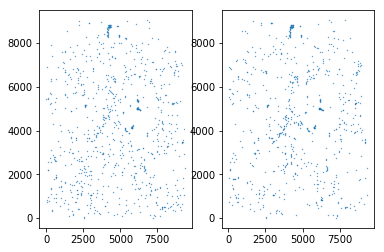

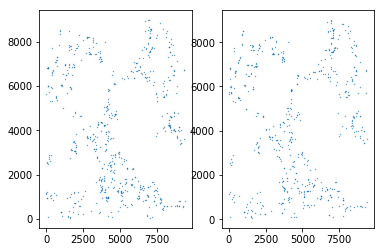

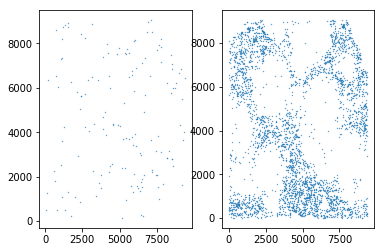

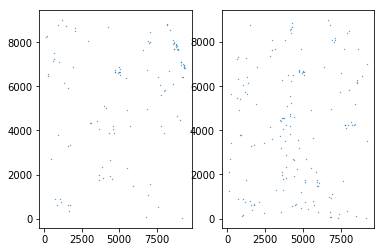

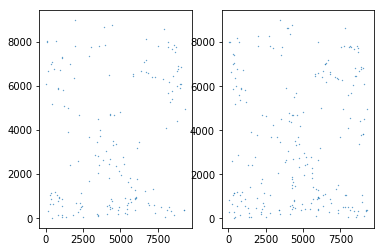

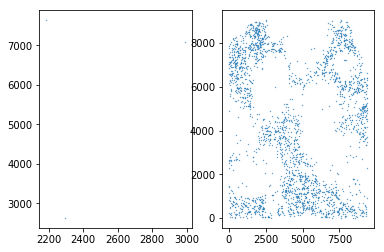

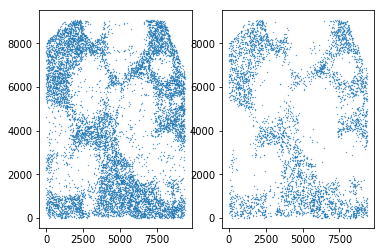

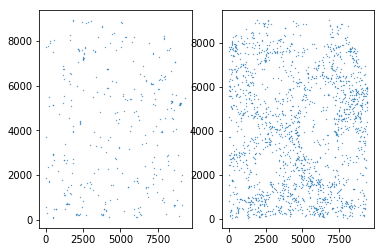

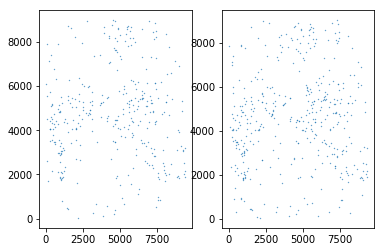

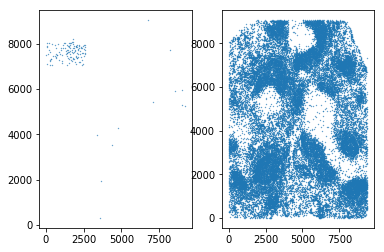

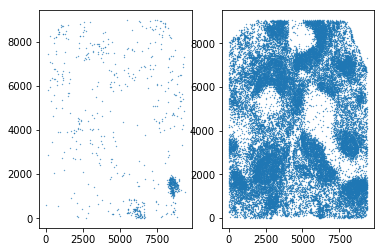

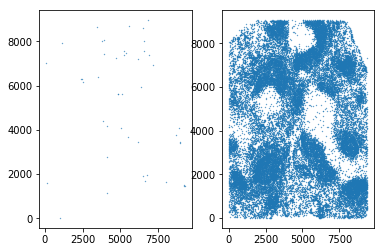

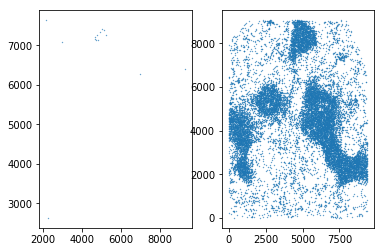

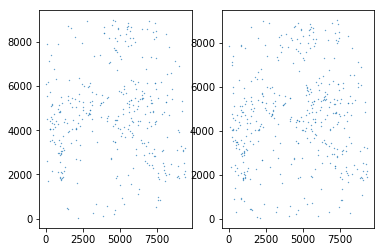

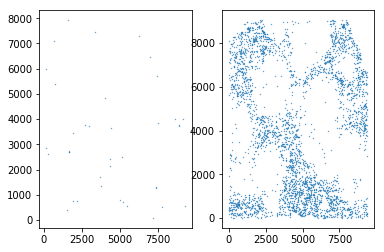

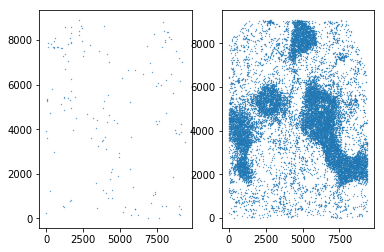

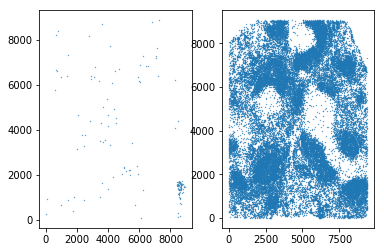

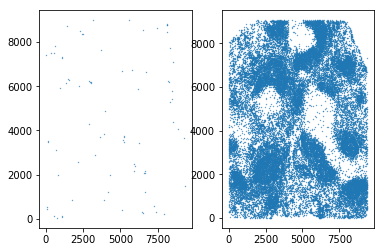

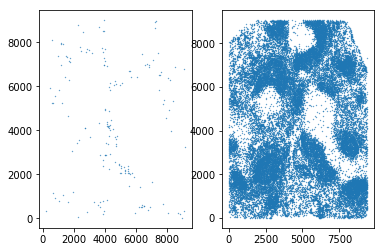

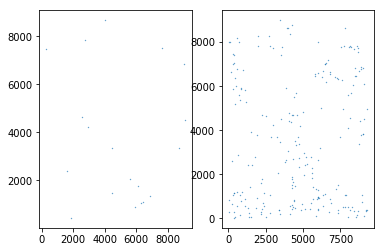

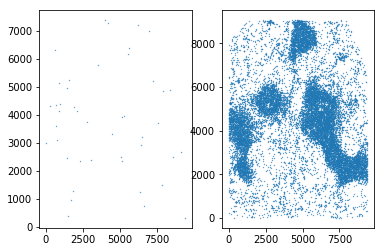

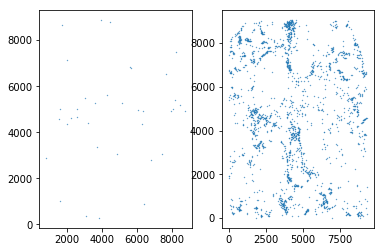

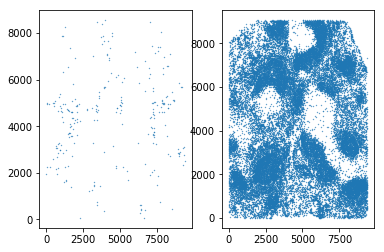

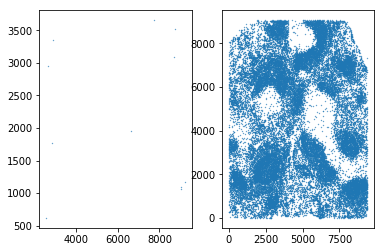

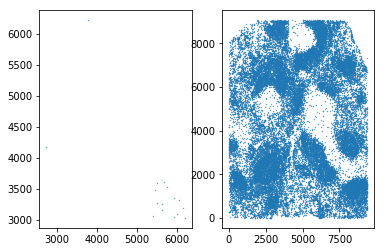

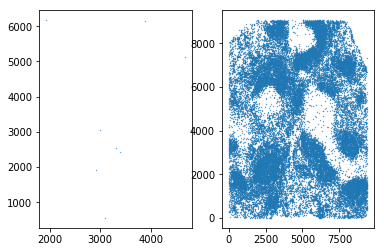

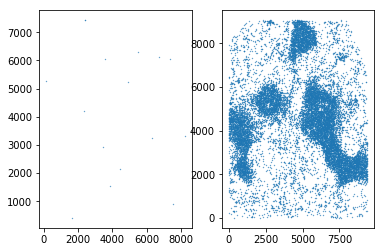

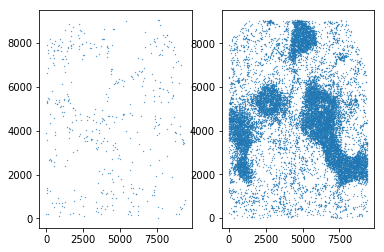

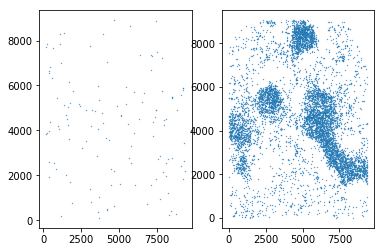

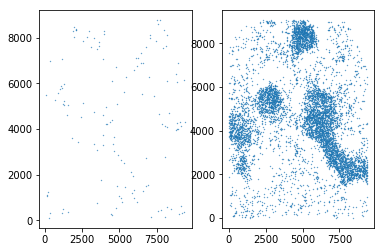

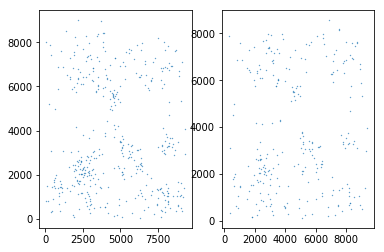

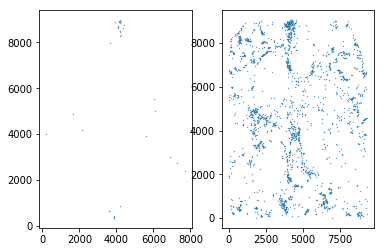

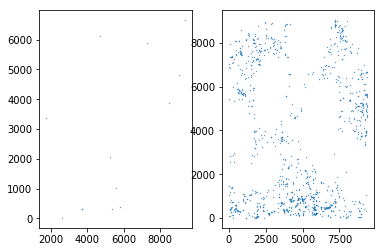

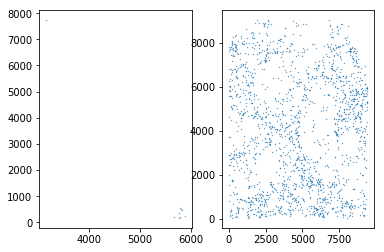

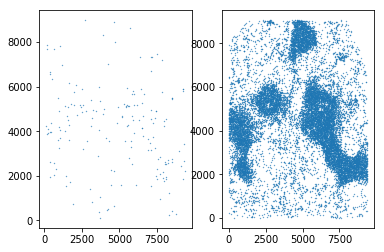

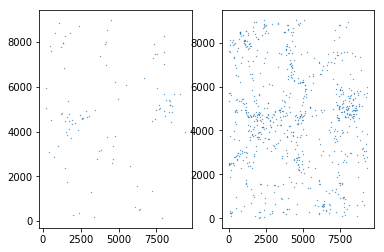

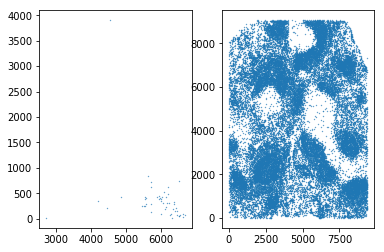

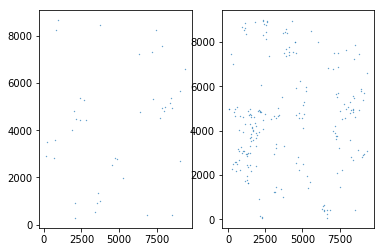

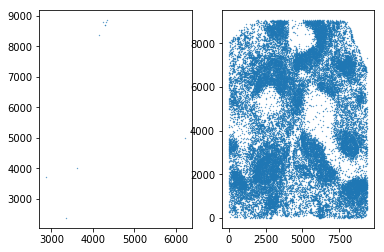

In [23]:
node_coords = [node.coords[['X', 'Y']] for node in parsed_metric_tree.iter_descendants()] 
suppl_image_coords = [group for _, group in suppl_image_groups]
find_corresponding_cluster(node_coords, suppl_image_coords)

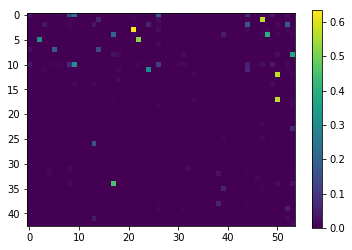

In [24]:
plot_cluster_overlap_heatmap(node_coords, suppl_image_coords)

Layer with 16 nodes


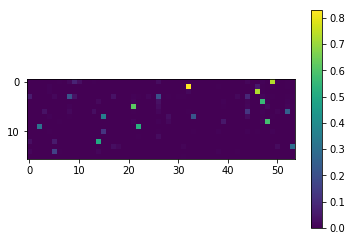

Layer with 17 nodes


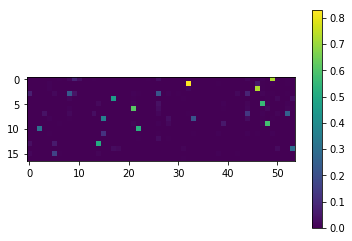

Layer with 18 nodes


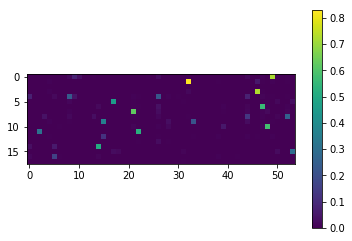

Layer with 17 nodes


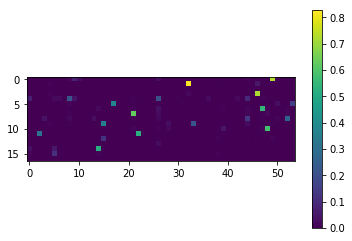

Layer with 18 nodes


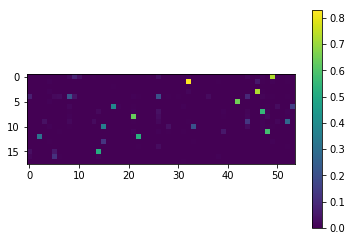

Layer with 19 nodes


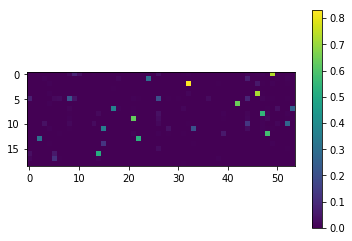

Layer with 21 nodes


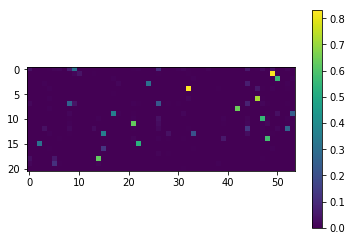

Layer with 22 nodes


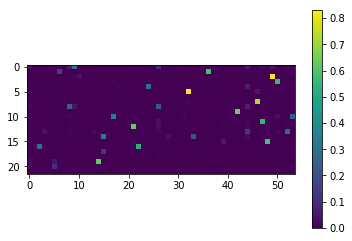

Layer with 21 nodes


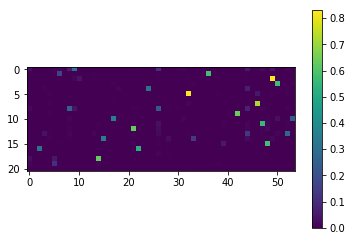

Layer with 20 nodes


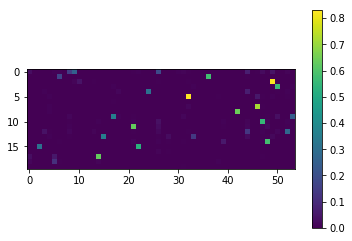

Layer with 21 nodes


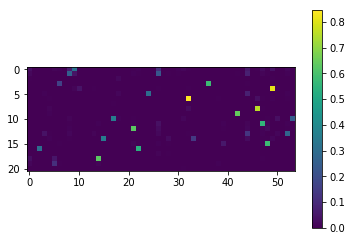

Layer with 22 nodes


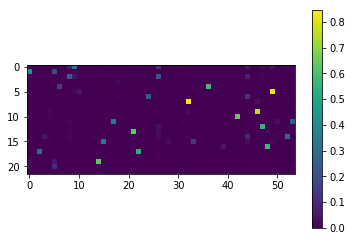

Layer with 23 nodes


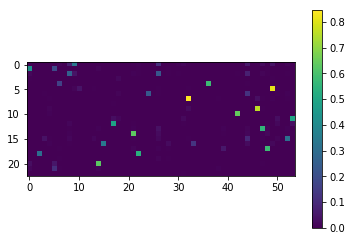

Layer with 24 nodes


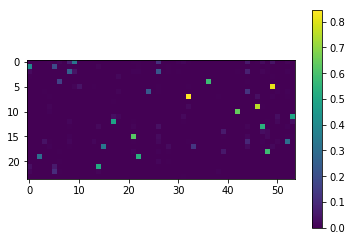

Layer with 22 nodes


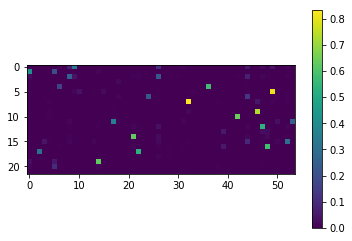

Layer with 24 nodes


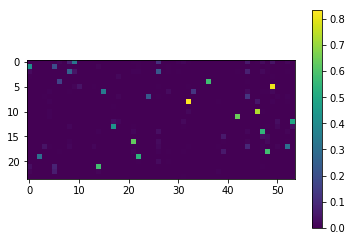

Layer with 27 nodes


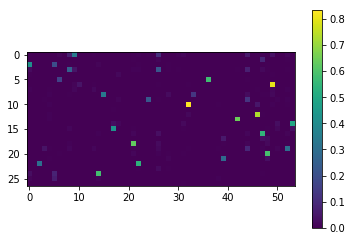

Layer with 29 nodes


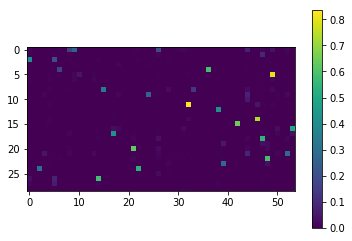

Layer with 28 nodes


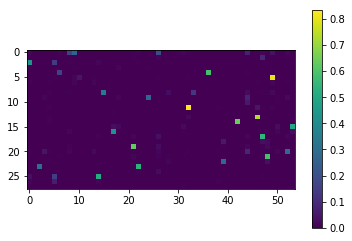

Layer with 30 nodes


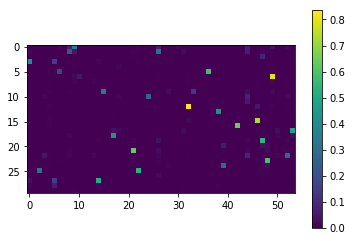

Layer with 31 nodes


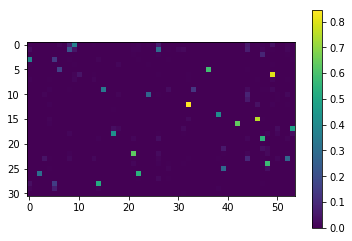

Layer with 32 nodes


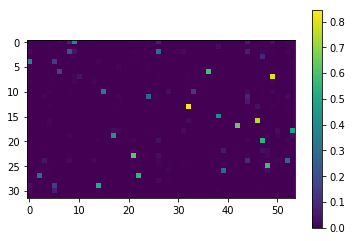

Layer with 33 nodes


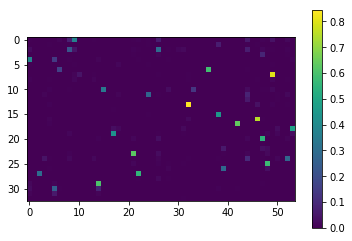

Layer with 34 nodes


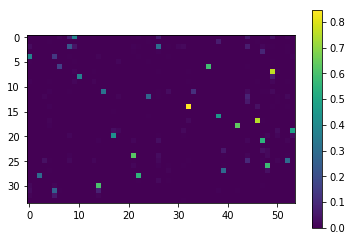

Layer with 36 nodes


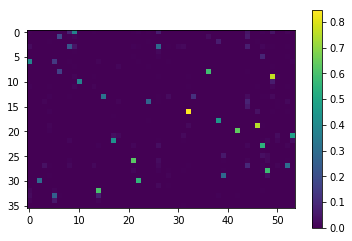

In [18]:
plot_layer_overlap_heatmap(tree, suppl_image_coords, num_layers=25)

## Rerun Above Analysis Over All Samples 

In [42]:
sample_name = 'combined'
num_clusters, num_neighbors = get_unique_clusters(sample_name)
pickle.dump((num_clusters, num_neighbors), open('combined_unique_clusters.pkl', 'wb'))
#num_clusters, num_neighbors = pickle.load(open('combined_unique_clusters.pkl', 'rb'))

In [43]:
fcs_paths = [data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs' for nn in num_neighbors]
tree = build_sample_tree(sample_name, prop_filter=0.15)
tree = calculate_spearman_metric(tree)
pickle.dump(tree, open('combined_tree.pkl', 'wb'))
#tree = pickle.load(open('combined_tree.pkl', 'rb'))

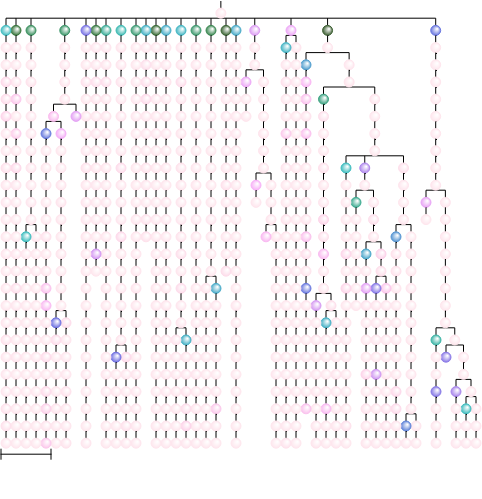

In [44]:
visualize_spearman_metric(num_layers=25, save=False)

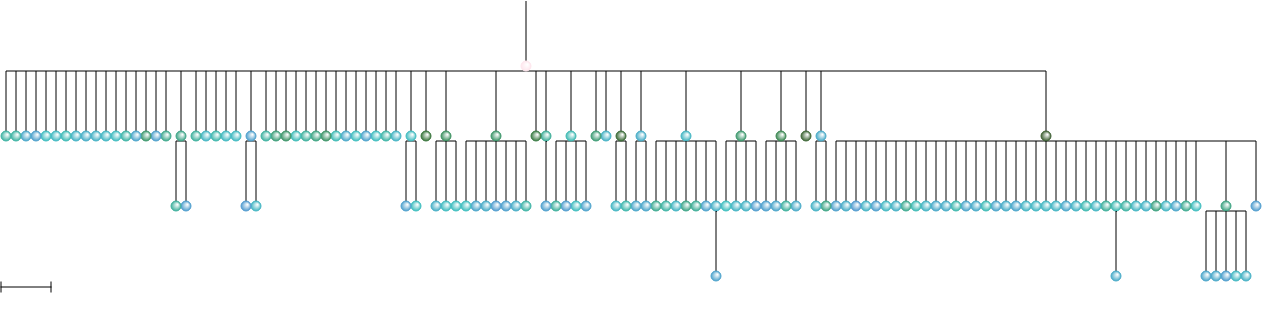

In [45]:
parse_metric_tree(tree, num_layers=None, cutoff=0.2, prevent_nondicotomic=False, save=False)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


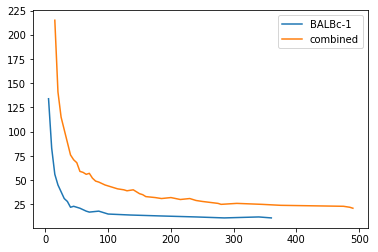

In [46]:
num_clusters_balbc1, num_neighbors_balbc1 = get_unique_clusters('BALBc-1')
num_clusters_combined, num_neighbors_combined = get_unique_clusters('combined')
plt.plot(num_neighbors_balbc1, num_clusters_balbc1, label='BALBc-1')
plt.plot(num_neighbors_combined, num_clusters_combined, label='combined')
plt.legend()
plt.show()

## Analyze Batch Effects in Samples 

In [22]:
# use cluster centroids from BALBc-1 to cluster others, and then compute mutual information between clusterings
_, balbc1_data = fcsparser.parse('BALBc-1/auto/out/BALBc-1.fcs')
balbc1_data = process_fcs(balbc1_data)
feature_cols = list(balbc1_data.columns[:29])
balbc1_data = balbc1_data[feature_cols + ['cluster_id']]
centroids = balbc1_data.groupby('cluster_id').apply(np.mean).reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1)
nn.fit(centroids[feature_cols].values)
remaining_samples = ['BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8']
for sample in remaining_samples:
    _, data = fcsparser.parse('{}/auto/out/{}.fcs'.format(sample, sample))
    data = process_fcs(data)
    data = data[feature_cols + ['cluster_id']]
    neighbors = nn.kneighbors(data[feature_cols].values, return_distance=False)[:, 0]
    score = mutual_info_score(data['cluster_id'].values, neighbors)
    print('Mutual info score for', sample, score)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


Mutual info score for BALBc-2 1.41636526374
Mutual info score for BALBc-3 1.37650504709
Mutual info score for MRL-4 1.2100834789
Mutual info score for MRL-5 1.18374105547
Mutual info score for MRL-6 1.17162112009
Mutual info score for MRL-7 1.09305823328
Mutual info score for MRL-8 1.17512264796


## Plot Tree Where Color Depends on Marker Expression 

In [2]:
# first make chart of most occuring cell types 
tree = pickle.load(open('tree_combined_for_html.pkl', 'rb'))
most_frequent = pd.DataFrame()
paths = list(get_paths(tree, num_layers=None))
most_frequent['Path ID'] = np.arange(len(paths))
most1, most2 = [], []
for ind, path in enumerate(get_paths(tree, num_layers=None)):
    densest = get_intersecting_cell_types(path, num_types=2)
    if densest:
        most1.append(densest[-1])
        most2.append(densest[-2])
    else:
        most1.append('N/A')
        most2.append('N/A')
most_frequent['Most Overlap'] = most1
most_frequent['Second Most Overlap'] = most2
display(most_frequent)
most_frequent.to_html('most_overlapping_cell_types.html')

Path ID              Most Overlap  \
0          0                   B cells   
1          1                   B cells   
2          2                   B cells   
3          3                   B cells   
4          4                   B cells   
5          5                   B cells   
6          6                   B cells   
7          7                   B cells   
8          8                   B cells   
9          9                   B cells   
10        10                   B cells   
11        11                   B cells   
12        12                   B cells   
13        13                   B cells   
14        14                   B cells   
15        15                   B cells   
16        16                   B cells   
17        17                   B cells   
18        18                   B cells   
19        19                   B cells   
20        20                   B cells   
21        21                   B cells   
22        22                   B cells   
23        23                   B cells   
24        24                   B cells   
25        25                   B cells   
26        26                   B cells   
27        27                   B cells   
28        28                   B cells   
29        29                   B cells   
..       ...                       ...   
277      277              plasma cells   
278      278              plasma cells   
279      279              plasma cells   
280      280              plasma cells   
281      281              plasma cells   
282      282           CD4(+)CD8(-)cDC   
283      283                       N/A   
284      284           CD4(+)CD8(-)cDC   
285      285           CD4(+)CD8(-)cDC   
286      286                       N/A   
287      287                      noid   
288      288                      noid   
289      289                      noid   
290      290                      noid   
291      291                      noid   
292      292                      noid   
293      293                      noid   
294      294                      noid   
295      295                      noid   
296      296                       N/A   
297      297                       N/A   
298      298  CD3(+) other markers (-)   
299      299  CD3(+) other markers (-)   
300      300  CD3(+) other markers (-)   
301      301  CD3(+) other markers (-)   
302      302                       N/A   
303      303                   capsule   
304      304           CD4(+)CD8(-)cDC   
305      305           CD4(+)CD8(-)cDC   
306      306           CD4(+)CD8(-)cDC   

                         Second Most Overlap  
0    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
1    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
2    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
3    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
4    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
5    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
6    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
7    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
8    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
9    CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
10   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
11   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
12   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
13   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
14   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
15   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
16   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
17   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
18   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
19   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
20   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
21   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
22   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
23   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
24   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
25   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
26   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
27   CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma  
28   CD106(+)CD16/32(+)CD31(-)Ly6C(-)

In [4]:
def get_node_markers(node, marker, suppl_converted):
    node_marker = pd.merge(node.coords, suppl_converted, how='inner', on=['X', 'Y', 'Z', 'sample'])
    marker_avg = node_marker[marker].mean()
    return marker_avg

def plot_marker_tree(tree, marker, resize_nodes=False, save=True):
    supplementary_data = pd.read_csv('../Suppl.Table2.CODEX_paper_MRLdatasetexpression.csv')
    supplementary_data.rename(columns={'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
    supplementary_data['CD45_int'] = supplementary_data['CD45'].astype(int)
    ids_to_names = pd.read_csv('ClusterIDtoName.txt', sep='\t')
    cell_lines = list(ids_to_names['ID'].values)
    ids_to_names = dict(zip(ids_to_names['ID'].values, ids_to_names['Name'].values))
    # remove dirt from supplementary data 
    supplementary_annotations = pd.read_excel('../Suppl.Table2.cluster annotations and cell counts.xlsx')
    dirt = supplementary_annotations.loc[supplementary_annotations['Imaging phenotype (cell type)'] == 'dirt', 
                                         'X-shift cluster ID']
    supplementary_data = supplementary_data[~supplementary_data['Imaging phenotype cluster ID'].isin(dirt)]
    supplementary_data['sample'] = supplementary_data['sample_Xtile_Ytile'].apply(lambda x: x.split('_')[0])
    suppl_converted = convert_coordinates(supplementary_data)[['X', 'Y', 'Z', 'sample', marker]]
    
    new_tree = TreeNode(name = tree.name)
    new_tree.img_style['size'] = 1 if resize_nodes else 10
    new_tree.img_style['fgcolor'] = hls2hex(0.1, 0.1, 0.1)
    new_tree.img_style['shape'] = 'sphere'
    
    marker_avgs = []
    old_layer = [tree]
    new_layer = [new_tree]
    layer_num = 0
    while old_layer:
        next_old_layer, next_new_layer = [], []
        for ind, node in enumerate(old_layer):
            for child in node.children:
                next_old_layer.append(child)
                new_child = TreeNode(name = child.name)
                marker_avg = get_node_markers(child, marker, suppl_converted)
                new_child.add_features(marker_avg=marker_avg)
                marker_avgs.append(marker_avg)
                new_layer[ind].add_child(new_child)
                next_new_layer.append(new_child)
        old_layer = next_old_layer
        new_layer = next_new_layer
        layer_num += 1
        
    marker_min, marker_max = np.min(marker_avgs), np.max(marker_avgs)
    for node in new_tree.iter_descendants():
        norm_marker = (node.marker_avg - marker_min) / (marker_max - marker_min)
        node.add_features(marker_avg=norm_marker)
        node.add_features(color=hls2hex(norm_marker*0.8 + 0.1, norm_marker*0.8 + 0.1, norm_marker*0.8 + 0.1))
        
    for node in new_tree.iter_descendants():
        node.img_style['size'] = 1 + 10 * node.marker_avg if resize_nodes else 10
        node.img_style['fgcolor'] = node.color
        node.img_style['shape'] = 'sphere'
        
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.rotation = 90
    ts.title.add_face(TextFace(marker, fsize=20), column=0)
    save_dir = 'Marker_Trees' if resize_nodes else 'Marker_Trees_Same_Size'
        
    if save:
        new_tree.render(save_dir + '/marker_tree_{}.png'.format(marker), tree_style=ts)
    else:
        return new_tree.render('%%inline', tree_style=ts)

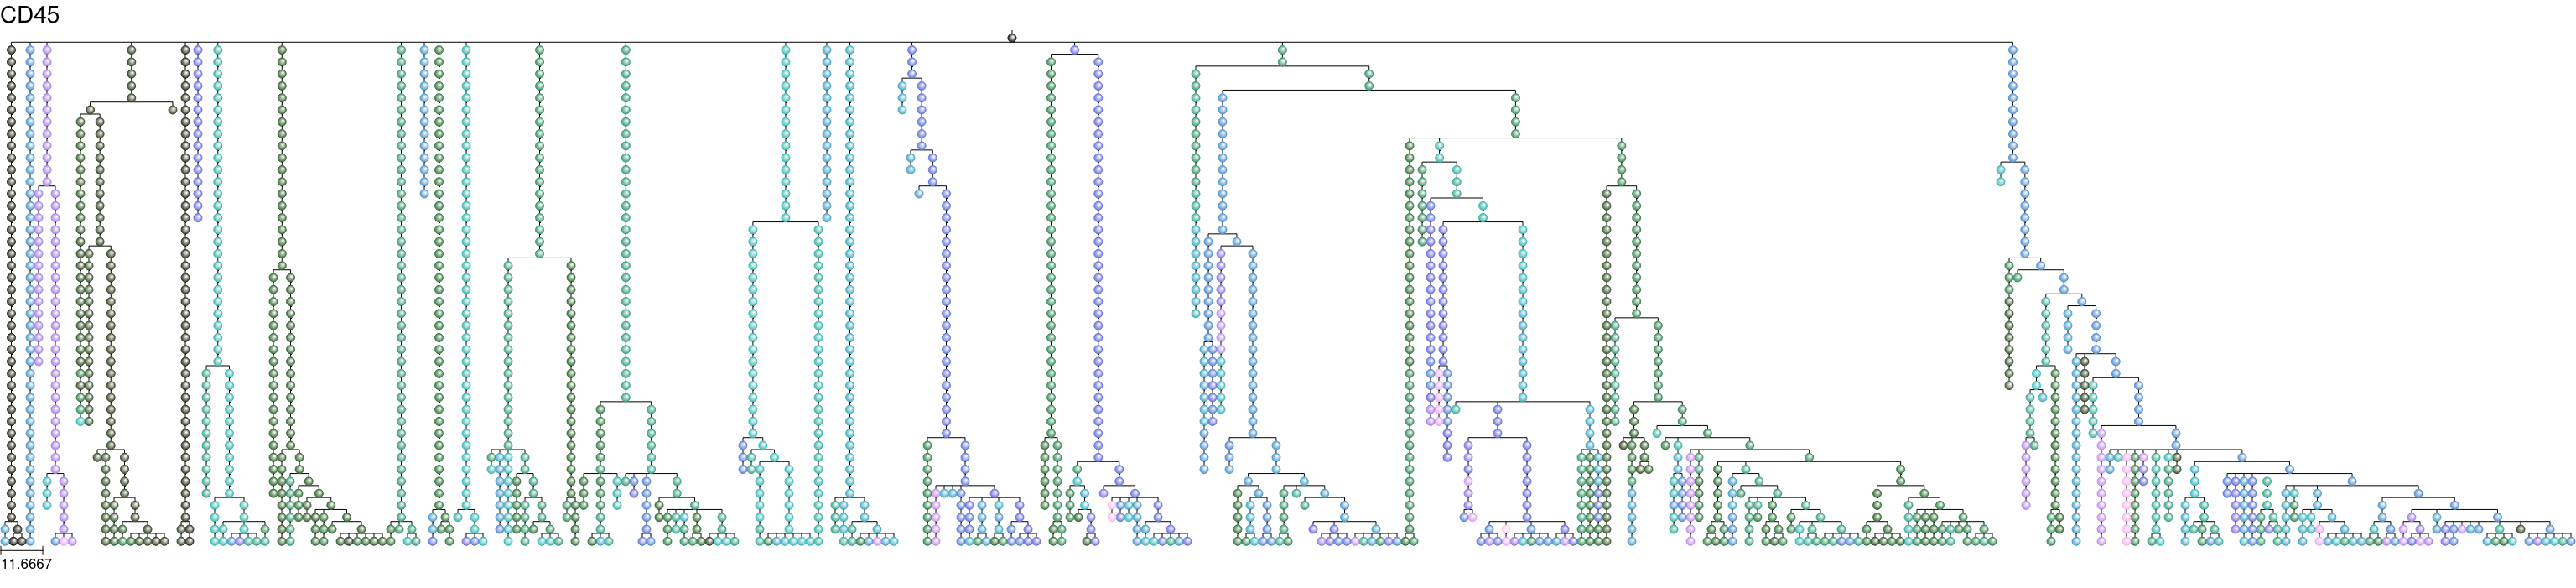

In [5]:
tree = pickle.load(open('tree_combined_for_html.pkl', 'rb'))
plot_marker_tree(tree, 'CD45', resize_nodes=False, save=False)

In [2]:
if not os.path.isdir('Marker_Trees'):
    os.mkdir('Marker_Trees')
if not os.path.isdir('Marker_Trees_Same_Size'):
    os.mkdir('Marker_Trees_Same_Size')
for marker in marker_cols:
    print('Submitting job for', marker)
    subprocess.Popen('sbatch create_marker_trees.sh {}'.format(marker), shell=True)

Submitting job for CD45
Submitting job for Ly6C
Submitting job for TCR
Submitting job for Ly6G
Submitting job for CD19
Submitting job for CD169
Submitting job for CD106
Submitting job for CD3
Submitting job for CD1632
Submitting job for CD8a
Submitting job for CD90
Submitting job for F480
Submitting job for CD11c
Submitting job for Ter119
Submitting job for CD11b
Submitting job for IgD
Submitting job for CD27
Submitting job for CD5
Submitting job for CD79b
Submitting job for CD71
Submitting job for CD31
Submitting job for CD4
Submitting job for IgM
Submitting job for B220
Submitting job for ERTR7
Submitting job for CD35
Submitting job for CD2135
Submitting job for CD44
Submitting job for NKp46
